<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Александр Уваров (@uvarov)

## <center> Индивидуальный проект по анализу данных </center>

Задача спрогнозировать размер следующего платежа пользователя в приложении. Попытка решения задачи регрессии не дала достаточно хороших результатов, поэтому сведем ее к задаче бинарной классификации.

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы

# Чтение и описание данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set_context("notebook")
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(10,5)

[Набор данных](https://drive.google.com/open?id=1ahOnFNDL6Yv2SnsMvL8SGI6KtSV6lAF7) представляет собой логи платежей пользователей Моего Мира в приложениях.

In [2]:
df = pd.read_csv('../../data/billing_data.csv', index_col=0)
df.shape

(20000, 20)

In [3]:
df.head()

,user_id,amount,app_id,service_id,service_name,bill_time,city_id,country_name,reg_time,city_name,sex,music_count,video_count,region_id,region_name,photo_count,apps,country_id,friends_count,birthday_time
598152,727654238,259,718311,68,Рубины,2017-01-31 01:30:41,25.0,Россия,14-01-2010 18:52,Москва,0,19,43,999999,Москва,60.0,"742452,690173,689414,718311,570177",24,885,29-12-1953 00:00
1755394,2972419216,25,675424,20,20 монет,2017-03-29 18:13:18,1658.0,Россия,21-05-2014 12:01,Калуга,1,0,0,289,Калужская обл.,1.0,"645611,725889,694143,703263,711108,706437,6754...",24,2,12-08-1961 00:00
1782131,391520684,299,690173,53,240 изумрудов,2017-03-31 08:32:09,592.0,Россия,09-05-2009 04:57,Чебоксары,1,0,1,251,Чувашия,9.0,"286662,572684,720278,537108,689343,739655,7024...",24,36,08-05-1967 00:00
1895114,565092602,499,548926,163,160 Бриллиантов,2017-04-06 18:40:57,1576.0,Россия,26-09-2008 12:22,Челябинск,0,22,1,282,Челябинская обл.,598.0,"541523,548484,689414,548926,648027,340533,3478...",24,138,12-07-1975 00:00
3066300,2698779374,1200,655199,1960687,37500 Рубинов,2017-06-14 22:50:29,526.0,Россия,11-10-2010 21:40,Нижний Новгород,1,37,0,242,Нижегородская обл.,2.0,"658788,212205,679164,645228,745880,644166,6722...",24,435,06-10-1970 00:00


**Описание признаков**

+ **amount** - размер платежа в мейликах (около 1 рубля). На ее основе будет получена целевая переменная.
+ **app_id** - идентификатор приложения
+ **service_id** - идентификатор типа оплаты
+ **bill_time** - дата оплаты
+ **city_id** - город пользователя (идентификатор)
+ **reg_time** - дата регистрации профиля
+ **sex** - пол (0 - женщины, 1 - мужчины)
+ **music_count** - количество аудиозаписей в профиле пользователя
+ **video_count** - количество видеозаписей в профиле пользователя
+ **region_id** - идентификатор географического региона
+ **photo_count** - количество фотографий в профиле пользователя
+ **apps** - список приложений пользователя
+ **country_id** - идентификатор страны
+ **friends_count** - количество друзей у пользователя
+ **birthday_time** - день рождения пользователя

Неиспользуемые:
+ **индекс** - идентификатор платежа
+ **user_id** - идентификатор пользователя
+ **service_name** - название типа оплаты
+ **country_name** - страна пользователя
+ **city_name** - город пользователя
+ **region_name** - название географического региона

Особенность данных в том, что мы имеем много категориальных признаков и относительно мало численных.

# Преобразование данных
Избавимся от некоторых признаков и записей:

In [4]:
df.drop('city_name', axis=1, inplace=True)
df.drop('region_name', axis=1, inplace=True)
df.drop('country_name', axis=1, inplace=True)

df.dropna(subset=['birthday_time', 'reg_time'], inplace=True)
df = df[(df['birthday_time'] != '') & (df['birthday_time'] != '01-01-1000 00:00')]

Будем прогнозировать оплату в конкретном приложении, но без учета сервиса. Поэтому уберем соответсвтующие признаки:

In [5]:
df.drop('service_name', axis=1, inplace=True)

Заполним некоторые пропуски:

In [6]:
df['city_id'].fillna('0', inplace=True)

df['photo_count'] = df['photo_count'].map(lambda x : 0 if x == '' else x)
df['photo_count'].fillna(0, inplace=True)
df['photo_count'] = df['photo_count'].astype('int')

Преобразуем типы столбцов:

In [7]:
df['app_id'] = df['app_id'].astype('object')
df['city_id'] = df['city_id'].astype('object')
df['region_id'] = df['region_id'].astype('object')
df['country_id'] = df['country_id'].astype('object')

time_columns = ['bill_time', 'reg_time', 'birthday_time']
for col in time_columns:
    df[col] = pd.to_datetime(df[col])

Кроме того, в данных есть пользователи с датой регистрации из будущего, удалим их:

In [8]:
df = df[(pd.Timestamp.now() - df['reg_time']) / np.timedelta64(1, 'D') > 0]

# Анализ данных

Посмотрим **распределение платежей по юзерам**:

In [9]:
bills_grouping_by_users = df.groupby('user_id')['amount'].sum()
bgu_desc = bills_grouping_by_users.describe()
print('В среднем за каждый юзер заплатил {} мейликов'.format(np.round(bgu_desc['mean'], 2)))
print('Самый платящий юзер оставил {} мейликов, что составило {}% от общей суммы платежей'.format(
    int(bgu_desc['max']), np.round(100 * bgu_desc['max'] / bills_grouping_by_users.sum(), 2)))

В среднем за каждый юзер заплатил 259.84 мейликов
Самый платящий юзер оставил 14616 мейликов, что составило 0.36% от общей суммы платежей


Накопленная по юзерам сумма платежей:

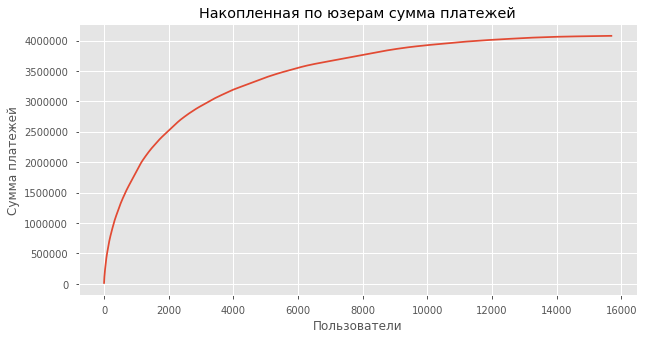

In [10]:
bills_users_cumsum = bills_grouping_by_users.sort_values(ascending=False).cumsum()
plt.plot(range(bills_grouping_by_users.shape[0]), bills_users_cumsum)
plt.title('Накопленная по юзерам сумма платежей')
plt.xlabel('Пользователи')
plt.ylabel('Сумма платежей');

In [11]:
for index, bill in enumerate(bills_users_cumsum):
    bills_percent = 100 * bill / bills_grouping_by_users.sum()
    if bills_percent > 80:
        users_percent = 100 * index / bills_grouping_by_users.shape[0]
        print('{}% прибыли нам приносят {}% пользователей'.format(
            int(np.round(bills_percent)), np.round(users_percent, 2)))
        break

80% прибыли нам приносят 27.65% пользователей


**Распределение платежей по приложениям:**

In [12]:
bills_grouping_by_apps = df.groupby('app_id')['amount'].sum()
bga_desc = bills_grouping_by_apps.describe()
print('В среднем каждое приложение заработало {} мейликов'.format(np.round(bga_desc['mean'], 1)))
print('Самое прибыльное приложение заработало {} мейликов, что составило {}% от общей суммы платежей'.format(
    int(bga_desc['max']), np.round(100 * bga_desc['max'] / bills_grouping_by_apps.sum(), 1)))

В среднем каждое приложение заработало 8637.6 мейликов
Самое прибыльное приложение заработало 469927 мейликов, что составило 11.5% от общей суммы платежей


Накопленная по приложениям сумма платежей:

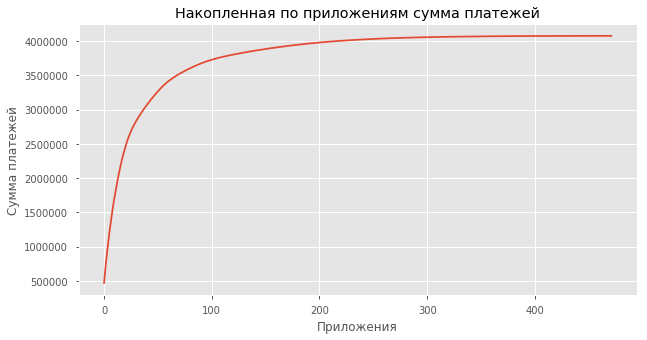

In [13]:
bills_apps_cumsum = bills_grouping_by_apps.sort_values(ascending=False).cumsum()
plt.plot(range(bills_grouping_by_apps.shape[0]), bills_apps_cumsum)
plt.title('Накопленная по приложениям сумма платежей')
plt.xlabel('Приложения')
plt.ylabel('Сумма платежей');

In [14]:
for index, bill in enumerate(bills_apps_cumsum):
    bills_percent = 100 * bill / bills_grouping_by_apps.sum()
    if bills_percent > 80:
        apps_percent = 100 * index / bills_grouping_by_apps.shape[0]
        print('Среди приложений лидеры играют еще большую роль: {}% прибыли нам приносят всего {}% приложений'.format(
            int(np.round(bills_percent)), np.round(apps_percent, 2)))
        break

Среди приложений лидеры играют еще большую роль: 80% прибыли нам приносят всего 10.59% приложений


Посмотрим распределение платежей между женщинами (0) и мужчинами (1):

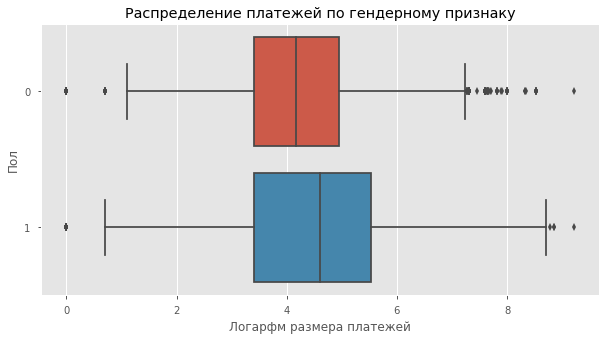

In [15]:
sns.boxplot(y=df["sex"], x=np.log(df["amount"]), orient="h")
plt.title('Распределение платежей по гендерному признаку')
plt.xlabel('Логарфм размера платежей')
plt.ylabel('Пол');

Как видим, мужчины в среднем платят больше.

Признак **'user_id'** больше нам не понадобится:

In [16]:
df.drop('user_id', axis=1, inplace=True)

# Добавление новых признаков

Новые признаки, связанные с типом покупки:

In [17]:
mm_app_id = 625595 # id приложения Мой Мир
df['mm_app'] = (df['app_id'] == mm_app_id).astype('uint8')

Признак количества контента:

In [18]:
df['content_count'] = df['photo_count'] + df['video_count'] + df['music_count']

Разделим существующие признаки на группы по типу. **Временные** признаки выделили ранее:

In [19]:
print(time_columns)

['bill_time', 'reg_time', 'birthday_time']


Обработаем временные данные:

In [20]:
time_dfs = []
for c in time_columns:
    # дни недели
    weekday_series = df[c].map(lambda x : x.weekday())
    time_dfs.append(pd.get_dummies(weekday_series, prefix=c+'_weekday'))
    
    # выходные
    holiday_series = ((weekday_series == 5) | (weekday_series == 6)).astype('uint8')
    holiday_series.name = c + '_holiday'
    time_dfs.append(holiday_series)
    
    # месяц
    month_series = df[c].map(lambda x : x.month)
    time_dfs.append(pd.get_dummies(month_series, prefix=c+'_month'))
    
    # число
    date_series = df[c].map(lambda x : x.day)
    time_dfs.append(pd.get_dummies(date_series, prefix=c+'_date'))
    
# возраст
df['age'] = np.round((pd.Timestamp.now() - df['birthday_time']) / np.timedelta64(1, 'D')).astype('int')

# возраст профиля
df['profile_age'] = np.round((pd.Timestamp.now() - df['reg_time']) / np.timedelta64(1, 'D')).astype('int')

# время оплаты
df['bill_time_hours'] = df['bill_time'].map(lambda x : x.hour)
df['bill_time_minutes'] = df['bill_time'].map(lambda x : x.minute)

time_df = pd.concat(time_dfs, axis=1)
df.drop(time_columns, axis=1, inplace=True)
time_df.shape

(19745, 151)

**Категориальные** признаки:

In [21]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
print(categorical_columns)

['app_id', 'service_id', 'city_id', 'region_id', 'apps', 'country_id']


Применим OHE для нескольких небинарных категориальных признаков. Сначала найдем эти признаки:

In [22]:
data_describe = df.describe(include=[object])
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2 and not c in ['apps', 'service_name']]
nonbinary_columns

['app_id', 'service_id', 'city_id', 'region_id', 'country_id']

Оценим, сколько признаков получится в результате OHE:

In [23]:
print(df[nonbinary_columns].describe().loc['unique'])
int(sum(df[nonbinary_columns].describe().loc['unique']))

app_id         472
service_id    7362
city_id       1181
region_id      426
country_id     110
Name: unique, dtype: object


9551

Применим OHE:

In [24]:
ohe_dfs = []
for c in nonbinary_columns:
    ohe_dfs.append(pd.get_dummies(df[c], prefix=c))
ohe_df = pd.concat(ohe_dfs, axis=1)
df.drop(nonbinary_columns, axis=1, inplace=True)
ohe_df.shape

(19745, 9551)

Преобразуем признак **'apps'** с использованием OHE:

In [25]:
has_apps_df = df['apps'].str.get_dummies(',').rename(columns=lambda col : 'has_app_' + col)
df.drop('apps', axis=1, inplace=True)
has_apps_df.shape

(19745, 1990)

Добавим признак количества установленных приложений:

In [26]:
df['apps_count'] = has_apps_df.sum(axis=1)

Признаки "активности" пользователя:

In [27]:
df['activity'] = df['content_count'] + df['apps_count'] + df['friends_count']
df['social_activity'] = df['apps_count'] + df['friends_count']
df['apps_per_age'] = df['apps_count'] / df['age']
df['apps_per_profile_age'] = df['apps_count'] / df['profile_age']

Выделим бинарные признаки:

In [28]:
binary_columns = ['sex', 'mm_app']

Перейдем к **численным** признакам:

In [29]:
numerical_columns = [c for c in df.columns if (c not in categorical_columns) and (c not in time_columns) and
                    (c not in binary_columns)]
print(numerical_columns)

['amount', 'music_count', 'video_count', 'photo_count', 'friends_count', 'content_count', 'age', 'profile_age', 'bill_time_hours', 'bill_time_minutes', 'apps_count', 'activity', 'social_activity', 'apps_per_age', 'apps_per_profile_age']


In [30]:
numerical_columns.remove('amount')

Посмотрим их распределение:

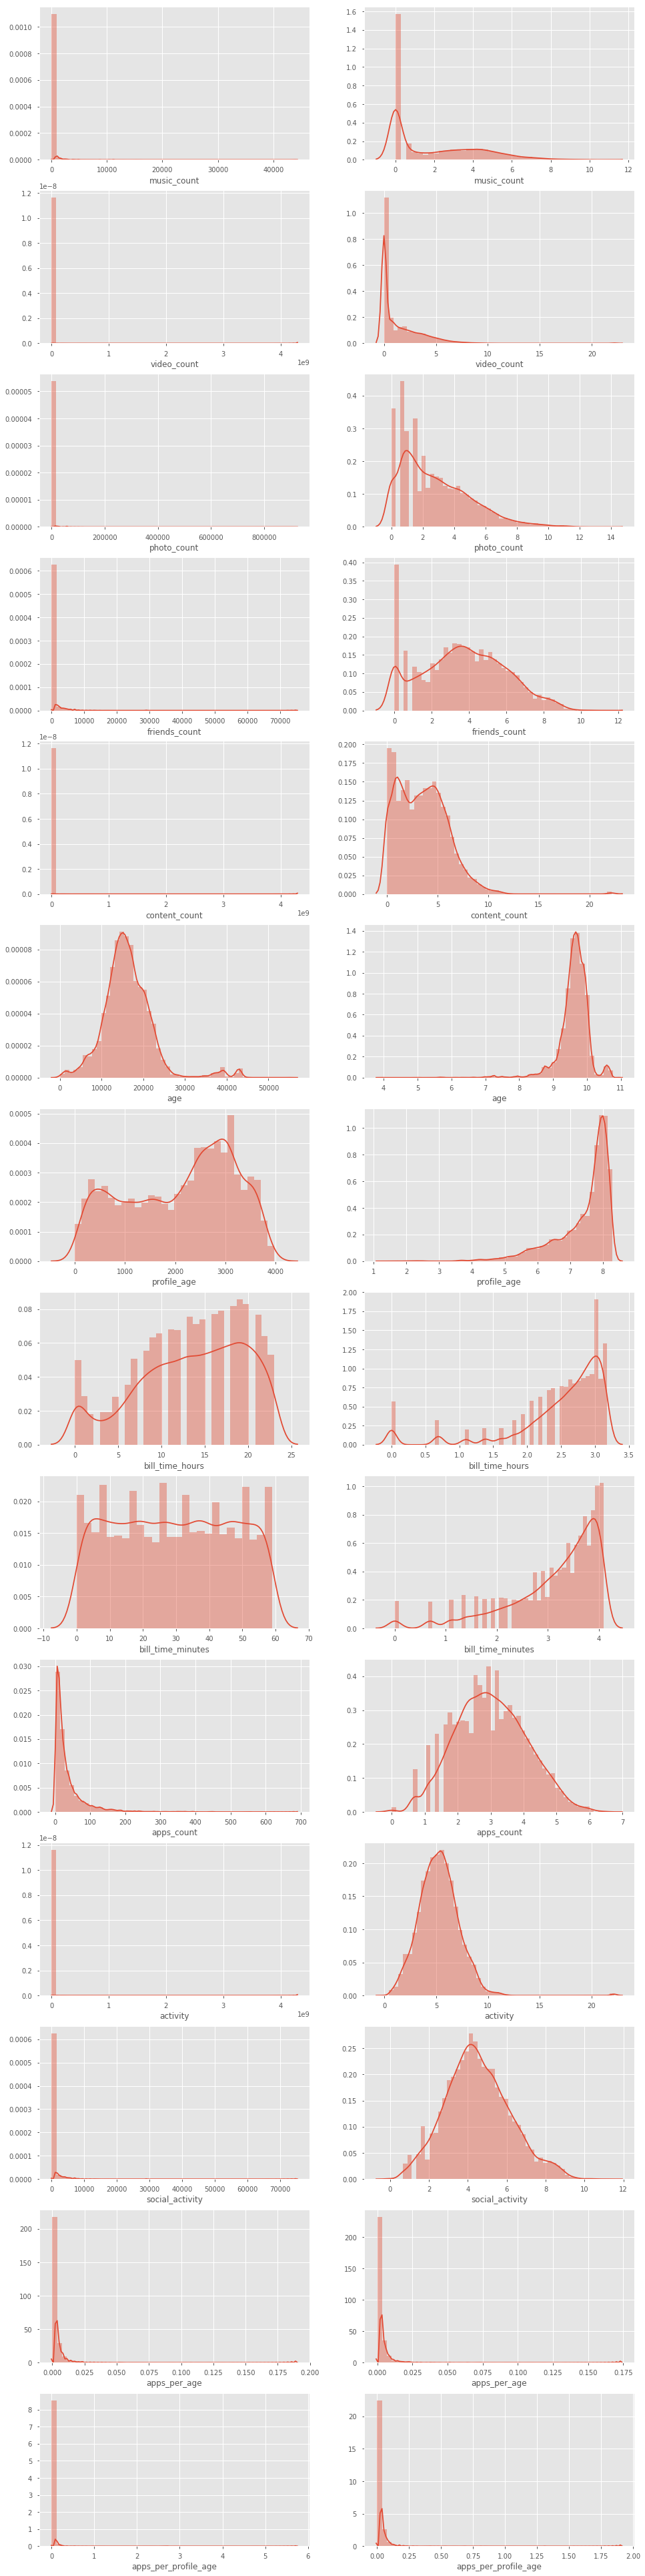

In [31]:
nc_count = len(numerical_columns)
_, axes = plt.subplots(nc_count, 2, figsize=(16, nc_count * 5))

for i, col in enumerate(numerical_columns):
    sns.distplot(df[col], ax=axes[i, 0]);
    sns.distplot(np.log(df[col] + 1), ax=axes[i, 1]);

Из графиков можно сделать вывод, что некоторые признаки лучше прологарифмировать:

In [32]:
log_columns = numerical_columns[:]
log_columns.remove('age')
log_columns.remove('profile_age')
log_columns.remove('bill_time_hours')
log_columns.remove('bill_time_minutes')

for col in log_columns:
    log_column_name = col + '_log'
    df[log_column_name] = np.log(df[col] + 1)
    df.drop(col, axis=1, inplace=True)

Теперь проведем нормализацию численных признаков:

In [33]:
scaler = StandardScaler()
for col in numerical_columns:
    if col not in df.columns:
        col += '_log'
    scaled_col = scaler.fit_transform(df[col].values.reshape(-1, 1))
    df[col] = scaled_col.flatten()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Соберем признаки вместе:

In [34]:
df = pd.concat([df, time_df, ohe_df, has_apps_df], axis=1)
del has_apps_df, ohe_df, time_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19745 entries, 598152 to 542398
Columns: 11709 entries, amount to has_app_98770
dtypes: float64(14), int64(1992), uint8(9703)
memory usage: 485.7 MB


Выделим целевую переменную:

In [35]:
y = df['amount']
df.drop('amount', axis=1, inplace=True)

Сведем задачу к задаче бинарной классификации. Разделим платежи медианой на 2 группы (маленькие платежи и большие):

In [36]:
y = (y > y.median()).astype('uint8')

# Кросс-валидация, подбор параметров

Поскольку целевой признак идеально сбалансирован, будем измерять метрику accuracy, которая используется по умолчанию в классификаторах. Сравним бейслайны нескольких алгоритмов классификации:

In [37]:
algs = [
    ['Решающее дерево', DecisionTreeClassifier(random_state=0)],
    ['Случайный лес', RandomForestClassifier(random_state=0)],
    ['Логистическая регрессия', LogisticRegression(random_state=0)],
]
for alg_name, classifier in algs:
    score = np.round(np.mean(cross_val_score(classifier, df, y, cv=3)), 4)
    print('{}: {}'.format(alg_name, score))

A Jupyter Widget

Решающее дерево: 0.7863
Случайный лес: 0.7011
Логистическая регрессия: 0.8355



SVC и GradientBoostingClassifier не удалось проверить за приемлемое время. Лучший результат показала логистическая регрессия, ее и возьмем. Подберем гиперпараметры:

In [38]:
C_range = np.logspace(0, 1, 30)
params = {
    'penalty': ['l1', 'l2'], 
    'C': C_range
}
grid = GridSearchCV(LogisticRegression(random_state=0), params)
grid.fit(df, y)
print(grid.best_score_, grid.best_params_)
best_penalty_gs = grid.best_params_['penalty']
best_C_gs = grid.best_params_['C']

0.849328944036 {'C': 3.8566204211634711, 'penalty': 'l1'}


#  Построение кривых валидации и обучения

In [39]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor = lines[0].get_color(), alpha=0.2)

Лучшее значение параметра C: 3.857, что совпадает с результатом GridSearch


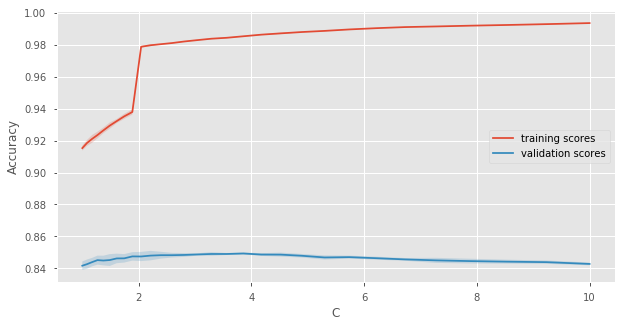

In [41]:
lr = LogisticRegression(penalty=best_penalty_gs, random_state=0)
val_train, val_test = validation_curve(lr, df, y, param_name='C', param_range=C_range)
plot_with_err(C_range, val_train, label='training scores')
plot_with_err(C_range, val_test, label='validation scores')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
 
best_C = C_range[val_test.mean(axis=1).argmax()]
print('Лучшее значение параметра C: {}, что совпадает с результатом GridSearch'.format(np.round(best_C, 3)))

На кривой валидации видно изменение метрики в зависимости от параметра С и его оптимальное значение, при котором метрика на валидации максимальна.

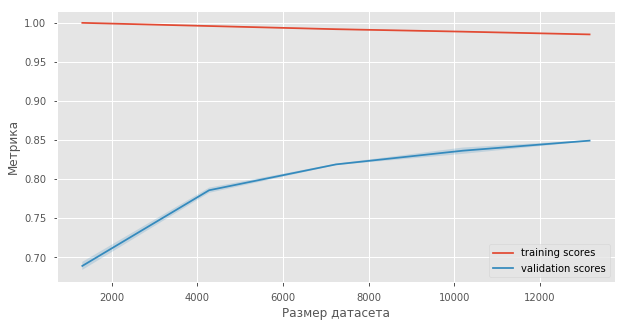

In [45]:
lr = LogisticRegression(penalty=best_penalty_gs, C=best_C, random_state=0)
N_train, learn_train, learn_test = learning_curve(lr, df, y, random_state=0)
plot_with_err(N_train, learn_train, label='training scores')
plot_with_err(N_train, learn_test, label='validation scores')
plt.xlabel('Размер датасета')
plt.ylabel('Метрика')
plt.legend();

По кривой обучения видно, что улучшить модель может увеличение количества данных, т.к. результаты на трейне и валидации продолжают сходиться.

# Прогноз для тестовой или отложенной выборки

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [46]:
lr = LogisticRegression(penalty=best_penalty_gs, C=best_C, random_state=0)
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
print('На отложенной выборке accuracy = {}'.format(np.round(accuracy_score(y_test, predict), 4)))

На отложенной выборке accuracy = 0.8509


# Выводы

Построена модель классификатора платежей в приложениях в социальной сети Мой Мир, предсказывающего их размер (большая сумма или маленькая). На отложенной выборке получили долю правильных предсказаний 85%, что является достаточно хорошим показателем.

С помощьу полученной модели можно предсказывать прибыль в зависимости от различных входных данных и создавать выгодные акции и предложения для пользователей, увеличивающие доход.